In [90]:
# Install necessary libraries
# pip install yfinance pandas numpy scikit-learn tensorflow matplotlib

# Import libraries
import datetime
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error

[*********************100%***********************]  1 of 1 completed


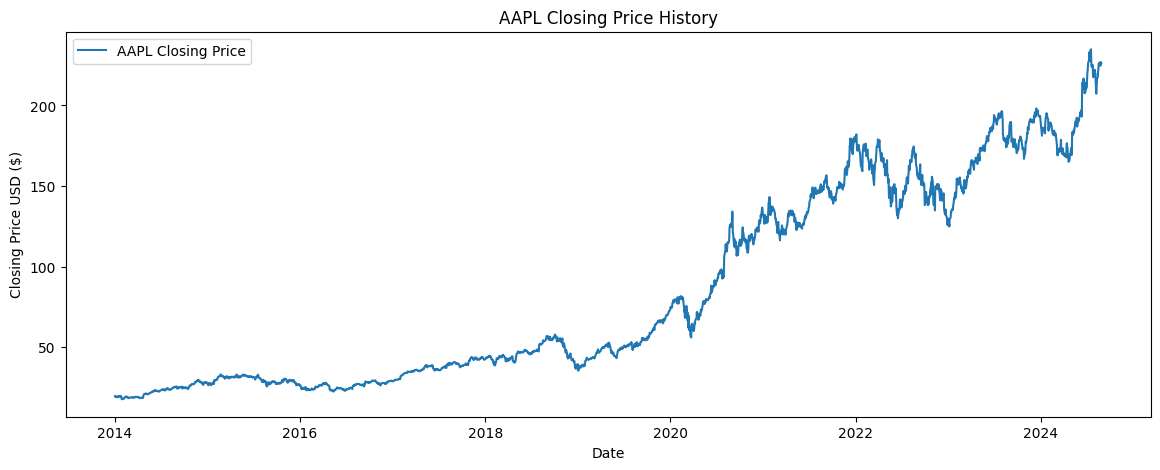

In [91]:
# Fetching the stock data
ticker = "AAPL"
data = yf.download(ticker, start="2014-01-01")

# Display the first few rows of the dataset
data.head()

# Plot the closing price history
plt.figure(figsize=(14, 5))
plt.plot(data['Close'], label=f'{ticker} Closing Price')
plt.title(f'{ticker} Closing Price History')
plt.xlabel('Date')
plt.ylabel('Closing Price USD ($)')
plt.legend()
plt.show()

In [92]:
# Adding a relative strength index (RSI) feature
def calculate_RSI(data, window=50):
    delta = data['Close'].diff(1)
    gain = (delta.where(delta > 0, 0)).fillna(0)
    loss = (-delta.where(delta < 0, 0)).fillna(0)
    avg_gain = gain.rolling(window=window).mean()
    avg_loss = loss.rolling(window=window).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

data['RSI'] = calculate_RSI(data)

# Fill missing values
data.fillna(method='backfill', inplace=True)

# Select relevant features
features = ['Close', 'RSI']
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[features])

/var/folders/4f/0g73fvd97x99r498f0q7wpzh0000gn/T/ipykernel_31524/3585839566.py:15: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='backfill', inplace=True)


In [93]:
def create_sequences(data, seq_length):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i + seq_length])
        targets.append(data[i + seq_length, 0])
    return np.array(sequences), np.array(targets)

seq_length = 5
X, y = create_sequences(scaled_data, seq_length)

# Splitting into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [94]:
from tensorflow.keras.layers import Bidirectional, GRU, Dropout, Dense, BatchNormalization, LSTM, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Improved Model
model = Sequential([
    Bidirectional(LSTM(100, return_sequences=True, kernel_regularizer=l2(0.05)), input_shape=(seq_length, X.shape[2])),
    Dropout(0.3),
    LSTM(100, kernel_regularizer=l2(0.05)),
    Dropout(0.3),
    Dense(25),
    Dense(1)
])

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error')

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

history = model.fit(X_train, y_train, epochs=75, batch_size=16, validation_data=(X_test, y_test), callbacks=[early_stopping, reduce_lr])

Epoch 1/75


/Users/adirathodd/Documents/GitHub/StockPrediction/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 6.4406 - val_loss: 0.0529 - learning_rate: 0.0010
Epoch 2/75
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0193 - val_loss: 0.0144 - learning_rate: 0.0010
Epoch 3/75
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0038 - val_loss: 0.0046 - learning_rate: 0.0010
Epoch 4/75
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0033 - val_loss: 0.0054 - learning_rate: 0.0010
Epoch 5/75
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0029 - val_loss: 0.0103 - learning_rate: 0.0010
Epoch 6/75
129/134 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0026
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0026 - val_loss: 0.0050 - learning_rate: 0.0010
Epoch 7/75
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0020 - val_loss: 0.0021 - learning_rate: 5.0000e-04
Epoch 8/75
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0023 - val_loss: 0.0036 - learning_rate: 5.

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step


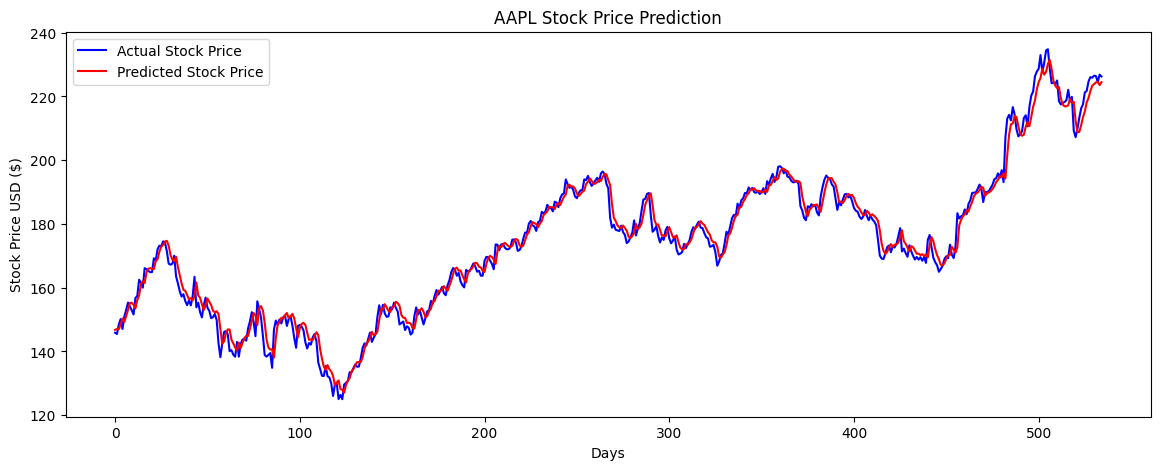

In [95]:
# Predicting on the test set
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(np.concatenate((predictions, np.zeros((predictions.shape[0], 1))), axis=1))[:, 0]

# Rescaling the test targets
y_test_rescaled = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], 1))), axis=1))[:, 0]

plt.figure(figsize=(14, 5))
plt.plot(y_test_rescaled, color='blue', label='Actual Stock Price')
plt.plot(predictions, color='red', label='Predicted Stock Price')
plt.title(f'{ticker} Stock Price Prediction')
plt.xlabel('Days')
plt.ylabel('Stock Price USD ($)')
plt.legend()
plt.show()

In [96]:
# Prepare input data for tomorrow's prediction
# Extract the last 'seq_length' data points from the original data to create the input sequence
last_sequence = scaled_data[-seq_length:]
# Reshape the last sequence to match the input shape expected by the model
last_sequence = last_sequence.reshape((1, seq_length, len(features)))

# 4. Make Prediction
predicted_price_scaled = model.predict(last_sequence)

predicted_price = scaler.inverse_transform(np.concatenate((predicted_price_scaled, np.zeros((predicted_price_scaled.shape[0], 1))), axis=1))[:, 0]

# Print the predicted price
print("Predicted closing stock price for tomorrow:", predicted_price[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Predicted closing stock price for tomorrow: 224.53653965840317


In [97]:
# Calculating error metrics
mse = mean_squared_error(y_test_rescaled, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_rescaled, predictions)

print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Error (MAE): {mae}')

Mean Squared Error (MSE): 9.66874268674693
Root Mean Squared Error (RMSE): 3.1094601921791716
Mean Absolute Error (MAE): 2.3673265654208873
